### Import Library and Data

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn import tree
from sklearn.metrics import accuracy_score , confusion_matrix , mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn import linear_model, tree, metrics, model_selection, exceptions, ensemble, metrics
from sklearn.metrics import fbeta_score

In [9]:
data_train = pd.read_csv("Data/train_validation_dataset.csv")
data_test = pd.read_csv("Data/test_dataset.csv")

<b> Note: EDA in notebook `Data_Extraction_and_Exploratory_Data_Analysis`

### Combining train and test data for pre-processing

In [10]:
# concatenating train and test set for pre-processing
# add a column to label train and test data, where train=0, test=1.

data_train['dataset'] = 0
data_test['dataset'] = 1
data = pd.concat([data_train, data_test])
print(data.shape)

(124900, 40)


<b> Pre-processing

In [11]:
# Change date column
from datetime import datetime
date = data['date']
data['date'] = pd.to_datetime(date).dt.strftime('%m/%Y')

# replace field that's entirely space (or empty) with NaN.
data = data.replace(r'^\s*$', 'NA', regex=True)

# impute missing values NaN with 0.
data = data.replace(np.nan, 0)

In [12]:
data = data.drop(['fullvisitorid', 'Unnamed: 0'], axis=1)

<b> Topic Modeling on keyword_today column

In [13]:
import operator
from sklearn import datasets, feature_extraction, naive_bayes, metrics
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

all_stopwords = nltk.corpus.stopwords.words('english')
all_stopwords+=['provided','www','com','https','(',')','0', '1hzbaqlcbjwfgoh7', '1x4me6zknv0zg-jv','6qehscssdk0z36ri',':','http']


count_vectorizer = feature_extraction.text.CountVectorizer(lowercase = True, stop_words=all_stopwords
                                                           ,token_pattern = '[a-z]+$',tokenizer = LemmaTokenizer(),
                                                           min_df=0.00005)

x1 = count_vectorizer.fit_transform(data['keyword_today'].apply(str))
vocab = count_vectorizer.get_feature_names()

C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [14]:
vocab

['+backpack',
 '+gear',
 '+google',
 '+google+tshirts',
 '+merch',
 '+merchandise',
 '+products',
 '+store',
 '+stores',
 '+swag',
 '+youtube',
 '//www.googlemerchandisestore.com/',
 'backpack',
 'bag',
 'buy',
 'company',
 'free',
 'gear',
 'google',
 'hoodie',
 'india',
 'lamp',
 'lava',
 'logo',
 'merch',
 'merchandise',
 'online',
 'pen',
 'remarketing/content',
 'shirt',
 'shop',
 'sticker',
 'store',
 't-shirt',
 'targeting',
 'tshirt',
 'tube',
 'youtube']

In [15]:
import numpy as np
from sklearn import datasets, feature_extraction, decomposition

n, m = x1.shape

In [19]:
lda_scores = []
my_range = range(2, 15)
for num_clusters in my_range:
    lda = decomposition.LatentDirichletAllocation(n_components = num_clusters, random_state = 2018)
    lda.fit_transform(x1)
    lda_scores.append(lda.score(x1))

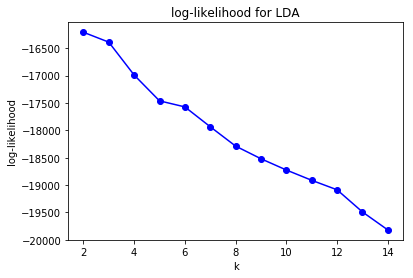

In [20]:
plt.plot(my_range, lda_scores,'b-o')
plt.xlabel("k")
plt.ylabel("log-likelihood")
plt.title('log-likelihood for LDA')
plt.show()

In [21]:
k = 5
lda = decomposition.LatentDirichletAllocation(n_components = k, random_state = 2019)
xtr = lda.fit_transform(x1)

In [22]:
topic_word = lda.components_
for j in range(m):
    topic_word[:, j] /= sum(topic_word[:,j])
for i in range(k):
    prob_j = []
    for j in range(m):
        prob_j.append((topic_word[i,j], j))
    
    prob_sorted = sorted(prob_j,reverse = True)
    print('topic', i+1)
    for j in range(5):
        print('   ', prob_sorted[j][0], vocab[prob_sorted[j][1]])

topic 1
    0.9945203625802006 targeting
    0.9945203625802006 remarketing/content
    0.9702158198518328 online
    0.9618170265362331 +stores
    0.9331379386668366 bag
topic 2
    0.9578926103601896 sticker
    0.7065017277472015 t-shirt
    0.661241181195373 merch
    0.5709165733314419 shirt
    0.4809585280755769 tshirt
topic 3
    0.9983658048077472 +google
    0.9970351855654251 +merchandise
    0.9964280175667923 +store
    0.9777586477331959 +products
    0.9732524419821073 tube
topic 4
    0.9974745399753018 youtube
    0.9817914694197615 +youtube
    0.9679953519436963 //www.googlemerchandisestore.com/
    0.9427631239197186 india
    0.9196159381432712 hoodie
topic 5
    0.9995591493144887 merchandise
    0.9992959436241021 store
    0.8560119397268657 google
    0.07993879123853544 shop
    0.025384215060620503 company


In [23]:
topic_cluster=pd.DataFrame(xtr, columns=['topic1', 'topic2','topic3', 'topic4','topic5'])

In [24]:
data=pd.concat([data.reset_index(), topic_cluster.reset_index()], axis=1).drop(['index','keyword_today'], axis=1)

<b> Transformations - Encode Categorical Data 

In [25]:
# Show Cateogrical columns using .select_dtypes()
cat_data = data.select_dtypes(include=[object]) # use this for sklearn's encoders

cat_data_cols = data.select_dtypes(
    include=[object]).columns  # use this for pd.get_dummies

print(cat_data.nunique())

date                 4
channelgrouping      8
campaign_today       5
medium_today         7
adcontent_today     24
devicecategory       3
continent            6
subcontinent        23
country            186
metro               71
city               354
operatingsystem      7
source_today         6
dtype: int64


In [26]:
data = pd.get_dummies(data, columns=cat_data_cols)

#### Split data back into train and test

- Split March-May 2017 data into Train and Validate <br>
- Jun 2017 data as Test <br>
- Perform MinMax Scaling <br>

In [27]:
# move col 'dataset' to the last col.
data = data[[c for c in data if c not in ['dataset']] + ['dataset']]
# move col 'transactions' to the last col.
data = data[[c for c in data if c not in ['transactions_target']] + ['transactions_target']]

In [28]:
train = data[data['dataset'] == 0]
test = data[data['dataset'] == 1]

<b> Split train data to train-validation

In [29]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

X = train.drop(['transactions_target', 'transactionrevenue_target'], axis=1)
y = train['transactions_target']

X_train, X_val , y_train, y_val=model_selection.train_test_split(X,y,test_size=0.3, random_state=1234)

X_train = min_max_scaler.fit_transform(X_train)
X_val = min_max_scaler.transform(X_val)

X_test = test.drop(['transactions_target', 'transactionrevenue_target'], axis=1)
y_test = test['transactions_target']

X_test = min_max_scaler.transform(X_test)

# Check train and test datasets
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(66424, 731)
(66424,)
(28468, 731)
(28468,)
(30008, 731)
(30008,)


## Classification Models

The following classification models were used: <br>
- Logistic Regression
- Random Forest
- Adaptive Boosting
- Light Gradient Boosting (LGB)
- Neural Network

<b> Define optimisation scorer

In [30]:
f2_scorer = metrics.make_scorer(metrics.fbeta_score, beta = 2)

<b> Define print score function

In [31]:
def print_score(model, X_test, y_test):
    predict=model.predict(X_test)
    print("Training score is {}".format(model.score(X_train, y_train)))
    print("Validation score is {}".format(model.score(X_test, y_test)))
    print('Recall:', recall_score(y_test, predict))
    print('Precision:', precision_score(y_test, predict))
    print('Accuracy:', accuracy_score(y_test, predict))
    print("f1:", f1_score(y_test, predict))
    print("f2:", fbeta_score(y_test, predict, beta=2), '\n')
    print('Classification Score')
    print(metrics.classification_report(y_test, predict))
    print('Confusion Matrix')
    print(metrics.confusion_matrix(y_test, predict))

## 1 - Logistic Regression

<b> Parameter Tuning

In [ ]:
# parameters = {'solver': ['newton-cg', 'sag','lbfgs'],
#                'C': [0.01, 0.05, 0.1, 0.2, 0.5]
#                }

# rs_lr = model_selection.RandomizedSearchCV(LogisticRegression(penalty='l2', random_state=1, class_weight='balanced'),
#                                             parameters,scoring = f2_scorer,
#                                             cv=model_selection.StratifiedKFold(
#                                                 n_splits=5, shuffle=True, random_state=2019),
#                                             verbose=2, n_jobs=-1)

# rs_lr.fit(X_train, y_train)

# #results
# rs_lr.best_estimator_
# #LogisticRegression(C=0.2, class_weight='balanced', dual=False,
# #                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
# #                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
# #                   random_state=1, solver='newton-cg', tol=0.0001, verbose=0,
# #                  warm_start=False)

<b> Logistic Regression Model

In [34]:
lr = LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

lr.fit(X_train,y_train)

LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

<b> Prediction with Validation Data (Logistic Regression)

In [35]:
print_score(lr, X_val, y_val)

Training score is 0.8519962664097315
Validation score is 0.8496908809891809
Recall: 0.8820798514391829
Precision: 0.1862014896119169
Accuracy: 0.8496908809891809
f1: 0.3074931218643793
f2: 0.5047821466524973 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     27391
           1       0.19      0.88      0.31      1077

    accuracy                           0.85     28468
   macro avg       0.59      0.87      0.61     28468
weighted avg       0.96      0.85      0.89     28468

Confusion Matrix
[[23239  4152]
 [  127   950]]


<b> Feature Importance (Logistic Regression)

In [37]:
lr_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': lr.coef_[0] })
print(lr_importance.sort_values('importance',ascending=False).head(10))

                          feature  importance
2                 pageviews_today   15.343374
1                      hits_today   14.273273
3                timeonsite_today    9.405874
19                transactions_lt    3.883427
123               country_Belgium    1.768600
154               country_Ecuador    1.740483
242           country_Puerto Rico    1.563075
37         channelgrouping_Social    1.395088
282  country_United Arab Emirates    1.387993
686                  city_Toronto    1.375152


In [38]:
print(lr_importance.sort_values('importance',ascending=False).tail(10))

                          feature  importance
410                   city_Boston   -0.834612
102  subcontinent_Southern Europe   -0.841397
161                country_France   -0.881557
238                  country_Peru   -0.915068
604      city_Piscataway Township   -0.921676
524             city_Laguna Beach   -0.923288
239           country_Philippines   -0.936465
276                country_Turkey   -1.017211
49          medium_today_referral   -1.244604
729       source_today_b'youtube'   -1.881231


## 2 - Random Forest Modelling

<b> Parameter Tuning

In [42]:
# parameters = {'criterion': ['gini', 'entropy'],
#                'max_depth': [5, 10, 15, 20],
#                'min_samples_leaf': [1, 2],
#                'min_samples_split': [2, 4, 6],
#                'n_estimators': [10, 20, 30, 40],
#                'class_weight': ['balanced', 'balanced_subsample', None]
#                }

# rs_rf = model_selection.RandomizedSearchCV(ensemble.RandomForestClassifier(random_state=1),
#                                             parameters, scoring = f2_scorer,
#                                             cv=model_selection.StratifiedKFold(
#                                                 n_splits=5, shuffle=True, random_state=2019),
#                                             verbose=2, n_jobs=-1)

# rs_rf.fit(X_train, y_train)
# # print('best parameters: ', rs_rf.best_params_)

# ##results
# rs_rf.best_estimator_
# # RandomForestClassifier(bootstrap=True, class_weight='balanced',
# #                        criterion='entropy', max_depth=20, max_features='auto',
# #                        max_leaf_nodes=None, min_impurity_decrease=0.0,
# #                        min_impurity_split=None, min_samples_leaf=2,
# #                        min_samples_split=6, min_weight_fraction_leaf=0.0,
# #                        n_estimators=40, n_jobs=None, oob_score=False,
# #                        random_state=1, verbose=0, warm_start=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

<b> Random Forest Model

In [43]:
rf = ensemble.RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)


rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

<b> Prediction with Validation Data (Random Forest)

In [44]:
print_score(rf, X_val, y_val)

Training score is 0.9228140431169457
Validation score is 0.9165378670788253
Recall: 0.8607242339832869
Precision: 0.2940057088487155
Accuracy: 0.9165378670788253
f1: 0.43829787234042555
f2: 0.6212303980699638 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     27391
           1       0.29      0.86      0.44      1077

    accuracy                           0.92     28468
   macro avg       0.64      0.89      0.70     28468
weighted avg       0.97      0.92      0.94     28468

Confusion Matrix
[[25165  2226]
 [  150   927]]


<b> Feature Importance for Random Forest

In [45]:
rf_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': rf.feature_importances_ })
print(rf_importance.sort_values('importance',ascending=False).head(10))

                           feature  importance
1                       hits_today    0.173371
2                  pageviews_today    0.139040
3                 timeonsite_today    0.131360
284          country_United States    0.042759
95   subcontinent_Northern America    0.040466
79              continent_Americas    0.027617
81                continent_Europe    0.025164
5                  newvisits_today    0.022085
8                          hits_st    0.019122
80                  continent_Asia    0.017970


## 3 - Adaptive Boosting

<b> Parameter Tuning

In [46]:
# parameters = {'base_estimator__criterion' : ["gini", "entropy"], 
#               'base_estimator__splitter' :   ["best", "random"],
#               'base_estimator__max_depth': [15, 20, 25, 30], 
#               'base_estimator__min_samples_split': list(range(15, 30, 5)),
#               'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1], 
#               'n_estimators': list(range(50, 200, 50))}

# DTC = tree.DecisionTreeClassifier(random_state = 2019, max_features = "auto", class_weight = "balanced")

# rs_ab = model_selection.RandomizedSearchCV(ensemble.AdaBoostClassifier(random_state = 2019, base_estimator = DTC), 
#                                   parameters, scoring = f2_scorer, 
#                                   cv = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2019),
#                                        iid=False, verbose=2, n_jobs=-1)

# rs_ab.fit(X_train, y_train)

# #results
# rs_ab.best_estimator_
# # AdaBoostClassifier(algorithm='SAMME',
# #                    base_estimator=DecisionTreeClassifier(class_weight='balanced',
# #                                                          criterion='gini',
# #                                                          max_depth=15,
# #                                                          max_features='auto',
# #                                                          max_leaf_nodes=None,
# #                                                          min_impurity_decrease=0.0,
# #                                                          min_impurity_split=None,
# #                                                          min_samples_leaf=1,
# #                                                          min_samples_split=15,
# #                                                          min_weight_fraction_leaf=0.0,
# #                                                          presort=False,
# #                                                          random_state=2019,
# #                                                          splitter='best'),
# #                    learning_rate=1, n_estimators=50, random_state=2019)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.9min finished


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=15,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=15,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=2019,
                     

<b> AdaBoost Model

In [47]:
from sklearn.tree import DecisionTreeClassifier

ab= ensemble.AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=15,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=15,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=2019,
                                                         splitter='best'),
                   learning_rate=1, n_estimators=50, random_state=2019)

ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=15,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=15,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=2019,
                     

<b> Prediction with Validation Data (Adaboost)

In [48]:
print_score(ab, X_val, y_val)

Training score is 0.8904161146573527
Validation score is 0.8796192215821274
Recall: 0.8245125348189415
Precision: 0.21522055259331072
Accuracy: 0.8796192215821274
f1: 0.3413415337305401
f2: 0.5264405975812189 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     27391
           1       0.22      0.82      0.34      1077

    accuracy                           0.88     28468
   macro avg       0.60      0.85      0.64     28468
weighted avg       0.96      0.88      0.91     28468

Confusion Matrix
[[24153  3238]
 [  189   888]]


<b> Feature Importance for Adaptive Boosting

In [49]:
ab_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': ab.feature_importances_ })
print(ab_importance.sort_values('importance',ascending=False).head(10))

                        feature  importance
2               pageviews_today    0.203025
284       country_United States    0.117162
1                    hits_today    0.087967
5               newvisits_today    0.084998
3              timeonsite_today    0.064711
75        devicecategory_mobile    0.035379
36     channelgrouping_Referral    0.019485
6                      ismobile    0.016795
81             continent_Europe    0.016110
722  operatingsystem_b'Windows'    0.014608


## 4 - Neural Network

In [73]:
from sklearn.neural_network import MLPClassifier
parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

rs_nn = model_selection.RandomizedSearchCV(MLPClassifier(random_state=2019, max_iter=100),
                                            parameters,scoring = f2_scorer,
                                            cv=model_selection.StratifiedKFold(
                                                n_splits=5, shuffle=True, random_state=2019),
                                            verbose=2, n_jobs=-1)

rs_nn.fit(X_train, y_train)
rs_nn.best_estimator_

# result
# MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
#               beta_2=0.999, early_stopping=False, epsilon=1e-08,
#               hidden_layer_sizes=(100,), learning_rate='constant',
#               learning_rate_init=0.001, max_iter=100, momentum=0.9,
#               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
#               random_state=2019, shuffle=True, solver='adam', tol=0.0001,
#               validation_fraction=0.1, verbose=False, warm_start=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 56.4min finished
C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [74]:
from sklearn.neural_network import MLPClassifier

nn= MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

nn.fit(X_train, y_train)

C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

<b> Prediction with Validation Data (Neural Network)

In [75]:
print_score(nn, X_val, y_val)

Training score is 0.9753552932674937
Validation score is 0.9672614865814247
Recall: 0.46332404828226553
Precision: 0.5849941383352872
Accuracy: 0.9672614865814247
f1: 0.5170984455958549
f2: 0.4834334431311761 

Classification Score
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     27391
           1       0.58      0.46      0.52      1077

    accuracy                           0.97     28468
   macro avg       0.78      0.73      0.75     28468
weighted avg       0.96      0.97      0.97     28468

Confusion Matrix
[[27037   354]
 [  578   499]]


## 5 - LightGBM

In [50]:
import lightgbm as lgb

<b> Parameter Tuning

In [52]:
# # coarse to fine tuning
# #parameter tuning guideline from: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# #Step 1 - coarse
# parameters = {'num_leaves': [10,20,30,40,50], 'min_data_in_leaf': [5, 10, 20, 30, 50, 100],'max_depth': [-1, 20, 40, 60, 100]}

# lgb_fit = model_selection.RandomizedSearchCV(lgb.LGBMClassifier(), parameters, scoring =  f2_scorer,
#                                    cv = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2019),
#                                             verbose=2, n_jobs=-1)
    
# lgb_fit.fit(X_train, y_train)
# print('best score:', lgb_fit.best_score_)
# print('best parameters: ', lgb_fit.best_params_)

# #results
# # best score: 0.4186322864004777
# # best parameters:  {'num_leaves': 30, 'min_data_in_leaf': 50, 'max_depth': 20}

# ##### Never do this ################################

# # Step 2 - fine
# # parameters = {'num_leaves': [30,50,70,90], 'min_data_in_leaf': [10,20,30,40],'max_depth': [100,120,140,160]}

# # lgb_fit = model_selection.RandomizedSearchCV(lgb.LGBMClassifier(), parameters, scoring =  f2_scorer,
# #                                    cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2019))
    
# # lgb_fit.fit(X_train, y_train)
# # print('best score:', lgb_fit.best_score_)
# # print('best parameters: ', lgb_fit.best_params_)
# # best score: 0.42790358761961755
# # best parameters:  {'num_leaves': 90, 'min_data_in_leaf': 10, 'max_depth': 160}

# # Note: to use step 1 tuning as it generate better score

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


best score: 0.4186322864004777
best parameters:  {'num_leaves': 30, 'min_data_in_leaf': 50, 'max_depth': 20}


<b> Light Gradient Boosting Model

In [53]:
lgb_c = lgb.LGBMClassifier(learning_rate = 0.04, n_estimators = 3200, boosting_type = 'dart', num_leaves = 30, min_data_in_leaf = 50, max_depth = 20)
lgb_c.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          eval_metric = None,
          verbose = 500)

[500]	valid_0's binary_logloss: 0.0801498
[1000]	valid_0's binary_logloss: 0.0788866
[1500]	valid_0's binary_logloss: 0.0786117
[2000]	valid_0's binary_logloss: 0.0788386
[2500]	valid_0's binary_logloss: 0.0792577
[3000]	valid_0's binary_logloss: 0.0799021


LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.04, max_depth=20,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=50, min_split_gain=0.0, n_estimators=3200,
               n_jobs=-1, num_leaves=30, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

<b> Prediction with Validation Data (LGB) 

In [54]:
print_score(lgb_c, X_val, y_val)

Training score is 0.9838462001686138
Validation score is 0.9697555149641703
Recall: 0.44939647168059427
Precision: 0.6436170212765957
Accuracy: 0.9697555149641703
f1: 0.5292509568069983
f2: 0.4782608695652174 

Classification Score
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     27391
           1       0.64      0.45      0.53      1077

    accuracy                           0.97     28468
   macro avg       0.81      0.72      0.76     28468
weighted avg       0.97      0.97      0.97     28468

Confusion Matrix
[[27123   268]
 [  593   484]]


In [55]:
lgb_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': lgb_c.feature_importances_ })
print(lgb_importance.sort_values('importance',ascending=False).head(10))

                   feature  importance
3         timeonsite_today       18056
2          pageviews_today       10935
1               hits_today        9337
10           timeonsite_st        4351
17           timeonsite_lt        3615
8                  hits_st        2313
9             pageviews_st        2182
15                 hits_lt        2130
16            pageviews_lt        2020
284  country_United States        1917


### Precision Recall Chart - Validation Data

In [76]:
lr_proba_val=lr.predict_proba(X_val)[:, 1]
rf_proba_val=rf.predict_proba(X_val)[:, 1]
ab_proba_val=ab.predict_proba(X_val)[:, 1]
nn_proba_val=nn.predict_proba(X_val)[:, 1]
lgb_proba_val=lgb_c.predict_proba(X_val, num_iteration=lgb_c.best_iteration_)[:,1]

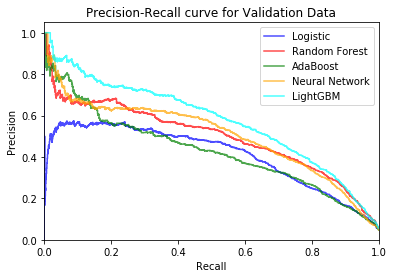

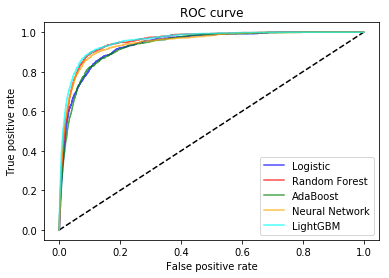

In [77]:
from inspect import signature

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_val, lr_proba_val)
rf_precision, rf_recall, _ = metrics.precision_recall_curve(y_val, rf_proba_val)
ab_precision, ab_recall, _ = metrics.precision_recall_curve(y_val, ab_proba_val)
nn_precision, nn_recall, _ = metrics.precision_recall_curve(y_val, nn_proba_val)
lgb_precision, lgb_recall, _ = metrics.precision_recall_curve(y_val, lgb_proba_val)

step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
plt.step(lr_recall, lr_precision, color='blue', alpha=0.7, where='post', label='Logistic')
plt.step(rf_recall, rf_precision, color='red', alpha=0.7, where='post', label='Random Forest')
plt.step(ab_recall, ab_precision, color='green', alpha=0.7, where='post', label='AdaBoost')
plt.step(nn_recall, nn_precision, color='orange', alpha=0.7, where='post', label='Neural Network')
plt.step(lgb_recall, lgb_precision, color='cyan', alpha=0.7, where='post', label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Validation Data')
plt.legend(loc='best')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_val, lr_proba_val)
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_proba_val)
fpr_ab, tpr_ab, _ = roc_curve(y_val, ab_proba_val)
fpr_nn, tpr_nn, _ = roc_curve(y_val, nn_proba_val)
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, lgb_proba_val)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic',color='blue', alpha=0.7)
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color='red', alpha=0.7)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost',color='green', alpha=0.7)
plt.plot(fpr_nn, tpr_nn, label='Neural Network',color='orange', alpha=0.7)
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM',color='cyan', alpha=0.7)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Model Comparison - Test Data

<b> 1. Prediction with Test Data (Logistic Regression)

In [78]:
print ('Logistic Regression')
print_score(lr, X_test, y_test)

Logistic Regression
Training score is 0.8519962664097315
Validation score is 0.834910690482538
Recall: 0.8777403035413154
Precision: 0.17794871794871794
Accuracy: 0.834910690482538
f1: 0.29590676520750425
f2: 0.49131583915423827 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.83      0.91     28822
           1       0.18      0.88      0.30      1186

    accuracy                           0.83     30008
   macro avg       0.59      0.86      0.60     30008
weighted avg       0.96      0.83      0.88     30008

Confusion Matrix
[[24013  4809]
 [  145  1041]]


<b> 2. Prediction with Test Data (Random Forest)

In [79]:
print ('Random Forest')
print_score(rf, X_test, y_test)

Random Forest
Training score is 0.9228140431169457
Validation score is 0.9054585443881632
Recall: 0.851602023608769
Precision: 0.2751293925360937
Accuracy: 0.9054585443881632
f1: 0.4158945851348569
f2: 0.6001188354129531 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     28822
           1       0.28      0.85      0.42      1186

    accuracy                           0.91     30008
   macro avg       0.63      0.88      0.68     30008
weighted avg       0.96      0.91      0.93     30008

Confusion Matrix
[[26161  2661]
 [  176  1010]]


<b> 3. Prediction with Test Data (Adaboost)

In [80]:
print ('AdaBoost')
print_score(ab, X_test, y_test)

AdaBoost
Training score is 0.8904161146573527
Validation score is 0.8668688349773394
Recall: 0.8178752107925801
Precision: 0.20425352705832808
Accuracy: 0.8668688349773394
f1: 0.3268744734625106
f2: 0.510902770462446 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     28822
           1       0.20      0.82      0.33      1186

    accuracy                           0.87     30008
   macro avg       0.60      0.84      0.63     30008
weighted avg       0.96      0.87      0.90     30008

Confusion Matrix
[[25043  3779]
 [  216   970]]


<b> 4. Prediction with Test Data (Neural Network)

In [81]:
print ('Neural Network')
print_score(nn, X_test, y_test)

Neural Network
Training score is 0.9753552932674937
Validation score is 0.9628099173553719
Recall: 0.4527824620573356
Precision: 0.5348605577689243
Accuracy: 0.9628099173553719
f1: 0.49041095890410963
f2: 0.46711899791231737 

Classification Score
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     28822
           1       0.53      0.45      0.49      1186

    accuracy                           0.96     30008
   macro avg       0.76      0.72      0.74     30008
weighted avg       0.96      0.96      0.96     30008

Confusion Matrix
[[28355   467]
 [  649   537]]


<b> 5. Prediction with Validation Data (Light Gradient Boosting)

In [82]:
print_score(lgb_c, X_test, y_test)

Training score is 0.9838462001686138
Validation score is 0.9657091442282059
Recall: 0.38701517706576727
Precision: 0.6031537450722734
Accuracy: 0.9657091442282059
f1: 0.4714946070878275
f2: 0.4168937329700273 

Classification Score
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     28822
           1       0.60      0.39      0.47      1186

    accuracy                           0.97     30008
   macro avg       0.79      0.69      0.73     30008
weighted avg       0.96      0.97      0.96     30008

Confusion Matrix
[[28520   302]
 [  727   459]]


### Precision Recall Chart - Test Data

In [85]:
lr_proba_test=lr.predict_proba(X_test)[:, 1]
rf_proba_test=rf.predict_proba(X_test)[:, 1]
ab_proba_test=ab.predict_proba(X_test)[:, 1]
nn_proba_test=nn.predict_proba(X_test)[:, 1]
lgb_proba_test=lgb_c.predict_proba(X_test, num_iteration=lgb_c.best_iteration_)[:,1]

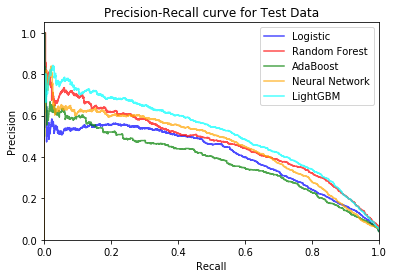

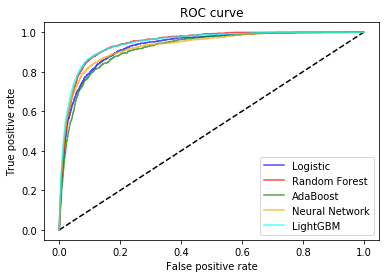

In [86]:
from inspect import signature

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, lr_proba_test)
rf_precision, rf_recall, _ = metrics.precision_recall_curve(y_test, rf_proba_test)
ab_precision, ab_recall, _ = metrics.precision_recall_curve(y_test, ab_proba_test)
nn_precision, nn_recall, _ = metrics.precision_recall_curve(y_test, nn_proba_test)
lgb_precision, lgb_recall, _ = metrics.precision_recall_curve(y_test, lgb_proba_test)

step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
plt.step(lr_recall, lr_precision, color='blue', alpha=0.7, where='post', label='Logistic')
plt.step(rf_recall, rf_precision, color='red', alpha=0.7, where='post', label='Random Forest')
plt.step(ab_recall, ab_precision, color='green', alpha=0.7, where='post', label='AdaBoost')
plt.step(nn_recall, nn_precision, color='orange', alpha=0.7, where='post', label='Neural Network')
plt.step(lgb_recall, lgb_precision, color='cyan', alpha=0.7, where='post', label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Test Data')
plt.legend(loc='best')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba_test)
fpr_ab, tpr_ab, _ = roc_curve(y_test, ab_proba_test)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_proba_test)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_proba_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic',color='blue', alpha=0.7)
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color='red', alpha=0.7)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost',color='green', alpha=0.7)
plt.plot(fpr_nn, tpr_nn, label='Neural Network',color='orange', alpha=0.7)
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM',color='cyan', alpha=0.7)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Threshold Curves - Test Data

In [87]:
def plot_prec_recall_vs_tresh(y_test, proba):
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, proba)
    
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.xlim([0,1.05])
    plt.ylim([0,1.05])

<b> Logistic Regression

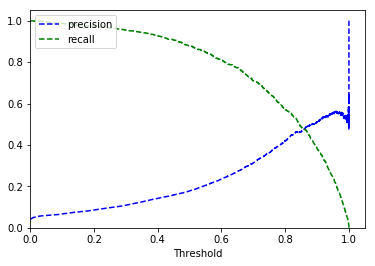

In [88]:
plot_prec_recall_vs_tresh(y_test, lr_proba_test)
plt.show()

<b> Random Forest

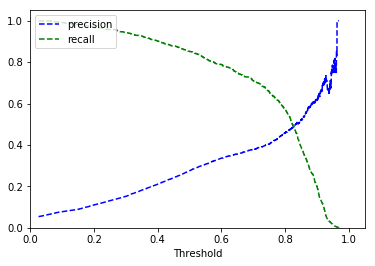

In [89]:
plot_prec_recall_vs_tresh(y_test, rf_proba_test)
plt.show()

<b> Adaptive Boosting

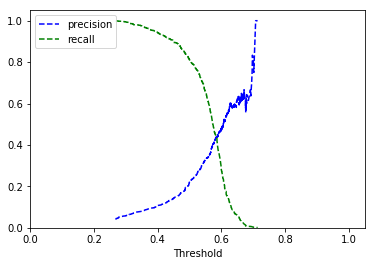

In [90]:
plot_prec_recall_vs_tresh(y_test, ab_proba_test)
plt.show()

<b> Neural Network

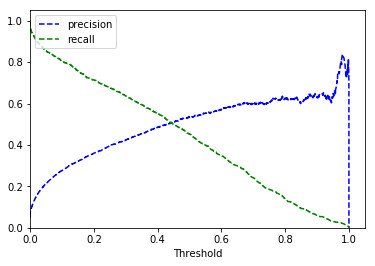

In [91]:
plot_prec_recall_vs_tresh(y_test, nn_proba_test)
plt.show()

<b> Light GBM

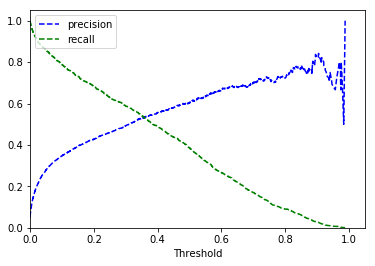

In [92]:
plot_prec_recall_vs_tresh(y_test, lgb_proba_test)
plt.show()

### Exporting Results

<b> Feature Importance

In [93]:
lr_importance.to_csv('Feature_Importance_04_LR.csv')
rf_importance.to_csv('Feature_Importance_04_RF.csv')
ab_importance.to_csv('Feature_Importance_04_AB.csv')
lgb_importance.to_csv('Feature_Importance_04_LGB.csv')

<b> Results

In [94]:
combine_proba=pd.concat([pd.DataFrame(lr_proba_test, columns=['Logistic_Regression']).reset_index(),
                         pd.DataFrame(rf_proba_test, columns=['Random_Forest']).reset_index(),
                         pd.DataFrame(ab_proba_test, columns=['AdaBoost']).reset_index(),
                         pd.DataFrame(nn_proba_test, columns=['Neural_Network']).reset_index(),
                         pd.DataFrame(lgb_proba_test, columns=['Light_GBM']).reset_index()
                        ], axis=1).drop('index', axis=1)

In [95]:
combine_with_data=pd.concat([pd.DataFrame(X_test, columns=X.columns).reset_index(), 
                             pd.DataFrame(y_test).reset_index(), 
                             combine_proba.reset_index()], axis=1).drop('index', axis=1)

In [96]:
combine_with_data.head(10)

,sessions,hits_today,pageviews_today,timeonsite_today,bounces_today,newvisits_today,ismobile,visits_st,hits_st,pageviews_st,...,source_today_b'others',source_today_b'partners',source_today_b'youtube',dataset,transactions_target,Logistic_Regression,Random_Forest,AdaBoost,Neural_Network,Light_GBM
0,0.0,0.0,0.004292,0.122858,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.264170,0.144556,0.326434,2.790090e-03,0.000265
1,0.0,0.0,0.004292,0.001648,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.000576,0.003343,0.268941,3.008386e-10,0.000002
2,0.0,0.0,0.004292,0.000577,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.072602,0.045432,0.348734,3.666418e-05,0.000158
3,0.0,0.0,0.004292,0.001071,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.053529,0.026722,0.319500,1.590192e-04,0.000211
4,0.0,0.0,0.004292,0.006427,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0,0.041214,0.045330,0.277528,7.976252e-06,0.000167
5,0.0,0.0,0.004292,0.000082,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.011210,0.016060,0.278264,2.665035e-11,0.000016
6,0.0,0.0,0.004292,0.003790,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.487408,0.186282,0.506649,1.142492e-03,0.003533
7,0.0,0.0,0.004292,0.001401,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.070097,0.054496,0.277528,4.779923e-05,0.000019
8,0.0,0.0,0.004292,0.015903,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.552088,0.358181,0.553950,2.105671e-02,0.008624
9,0.0,0.0,0.004292,0.001401,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.449583,0.336540,0.378163,1.800615e-02,0.016358


In [97]:
combine_with_data.to_csv('Result_04_w_FE.csv')

<b> Save Model

In [99]:
import pickle

with open('LR_04.pkl', 'wb') as file:  
    pickle.dump(lr, file)
    
with open('RF_04.pkl', 'wb') as file:  
    pickle.dump(rf, file)
    
with open('AB_04.pkl', 'wb') as file:  
    pickle.dump(ab, file)
    
with open('NN_04.pkl', 'wb') as file:  
    pickle.dump(nn, file)

with open('LightGBM_04.pkl', 'wb') as file:  
    pickle.dump(lgb_c, file)

### Outlier Detection 

<b> Reconfigure X_train and X_test for Outlier detection </b><br>
concat X_train and y_train -> this is for fit <br>
slice out only the values for 'transasction_target==0' -> this is for predict <br>
concat X_test and y_test -> this is for validation <br>

In [59]:
train_w_label = pd.concat([pd.DataFrame(X_train, columns=X.columns).reset_index(), y_train.reset_index()], axis=1).drop('index', axis=1)

In [60]:
train_outlier = train_w_label.loc[train_w_label['transactions_target'] == 0].drop('transactions_target', axis=1)

In [61]:
test_outlier = train_w_label.drop('transactions_target', axis=1)

## Outlier Detection using OneClassSVM

In [62]:
import pickle
from sklearn.svm import OneClassSVM
from sklearn import svm

#### RandomSearchCV

In [ ]:
oneclass = svm.OneClassSVM()
print(oneclass.get_params())

{'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 'auto_deprecated', 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.5, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [ ]:
parameters = { 
              'gamma': [0.05, 0.1, 0.5, 0.95]
              }

oneclass_rs = model_selection.RandomizedSearchCV(svm.OneClassSVM(nu=0.04, kernel='rbf' , random_state=2019), 
                                        parameters, scoring = f2_scorer, 
                                        cv = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2019), 
                                        verbose = 2, n_jobs = -1) 

oneclass_rs.fit(train_outlier)

# # save the model to disk
# filename = 'oneClassSVM_rs1.pkl'
# pickle.dump(oneclass, open(filename, 'wb'))

# # load the model from disk
# oneclass_fit_rs = pickle.load(open(filename, 'rb'))

# print('best parameters: ', oneclass_fit_rs.best_params_)

# result
# OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
#             kernel='rbf', max_iter=-1, nu=0.04, random_state=None,
#             shrinking=True, tol=0.001, verbose=False)

In [68]:
oneclass = svm.OneClassSVM(kernel='rbf', nu=0.04, gamma=0.001)

oneclass.fit(train_outlier)

# save the model to disk
filename = 'oneClassSVM_2.pkl'
#pickle.dump(oneclass, open(filename, 'wb'))

# load the model from disk
#oneclass_fit = pickle.load(open(filename, 'rb'))

In [ ]:
oneclass.support_vectors_.shape

In [69]:
oneclass_pred = oneclass.predict(test_outlier)

In [70]:
# Check the number of outliers predicted by the algorithm

unique, counts = np.unique(oneclass_pred, return_counts=True)
print (np.asarray((unique, counts)).T)

[[   -1  2630]
 [    1 63794]]


In [71]:
pred=pd.DataFrame(oneclass_pred).replace(1,0).replace(-1,1)

In [72]:
print(metrics.classification_report(train_w_label['transactions_target'], pred.values.tolist()))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     63811
           1       0.03      0.03      0.03      2613

    accuracy                           0.92     66424
   macro avg       0.49      0.49      0.49     66424
weighted avg       0.92      0.92      0.92     66424



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('Accuracy:', accuracy_score(train_w_label['transactions_target'], pred.values.tolist()))
print('Precision:', precision_score(train_w_label['transactions_target'], pred.values.tolist()))
print('Recall:', recall_score(train_w_label['transactions_target'], pred.values.tolist()))

### Isolation Forest

In [ ]:
import pickle
from sklearn.ensemble import IsolationForest

#### RandomSearchCV

In [ ]:
iforest = IsolationForest()
print(iforest.get_params())

In [ ]:
#f2_scorer = metrics.make_scorer(metrics.fbeta_score, beta = 2)

parameters = {
              'n_estimators': [50, 100, 200], 
              'contamination': [float(.12),'auto'], 
              'bootstrap': [True, False]
              }

iforest_rs = model_selection.RandomizedSearchCV(IsolationForest(), 
                                        parameters, scoring = f2_scorer, 
                                        cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2019), 
                                        verbose = 2, n_jobs = -1) 

iforest_rs.fit(train_outlier)

# save the model to disk
filename = 'iforest_rs1.pkl'
pickle.dump(oneclass, open(filename, 'wb'))

# load the model from disk
iforest_fit_rs = pickle.load(open(filename, 'rb'))


print('best parameters: ', iforest_fit_rs.best_params_)

In [ ]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

iforest.fit(train_outlier)

# save the model to disk
filename = 'isolation_forest1.pkl'
pickle.dump(iforest, open(filename, 'wb'))
 
# load the model from disk
iforest_fit = pickle.load(open(filename, 'rb'))


In [ ]:
iforest_pred = iforest_fit.predict(train_w_label)

In [ ]:
unique, counts = np.unique(iforest_pred, return_counts=True)
print (np.asarray((unique, counts)).T)

In [ ]:
pred=pd.DataFrame(iforest_pred).replace(1,0).replace(-1,1)

In [ ]:
print(metrics.classification_report(test, pred)) 

In [ ]:
print('Accuracy:', accuracy_score(test, pred))
print('Precision:', precision_score(test, pred)) 
print('Recall:', recall_score(test, pred))

In [ ]:
# iforest.decision_function(train_outlier)